# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

Trained with an updated model architecture, CNNMFCCs2


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_2'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt', patience=7)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs2 import CNNMFCCs2

model = CNNMFCCs2()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs2(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 52.30it/s, Loss=0.9618767499923706, Elapsed=1.6017s, ETA=0.0000s]


Epoch 1 completed in 8.2160s
Train Loss: 1.2965805718319954 - Train Accuracy: 42.31473734198684
Validation Loss: 1.0787852509816487 - Validation Accuracy: 51.05529759392149

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.51it/s, Loss=0.8973063230514526, Elapsed=1.4039s, ETA=0.0000s]


Epoch 2 completed in 6.6941s
Train Loss: 0.9950263410634388 - Train Accuracy: 55.61158725492413
Validation Loss: 0.8906576895713806 - Validation Accuracy: 62.27311101730688

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 71.12it/s, Loss=1.5907025337219238, Elapsed=1.2511s, ETA=0.0000s]

Epoch 3 completed in 6.3836s
Train Loss: 0.8877982862422921 - Train Accuracy: 60.60695144840687
Validation Loss: 0.8997240606943766 - Validation Accuracy: 60.63739974672858

EarlyStopping counter: 1/7
Epoch 4/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.09it/s, Loss=0.7119860053062439, Elapsed=1.3597s, ETA=0.0000s]

Epoch 4 completed in 6.4475s
Train Loss: 0.8189156675614373 - Train Accuracy: 63.72085660658963
Validation Loss: 0.8099350110689799 - Validation Accuracy: 66.31490080202617

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.16it/s, Loss=0.777515172958374, Elapsed=1.2579s, ETA=0.0000s] 

Epoch 5 completed in 6.1246s
Train Loss: 0.7820803347350544 - Train Accuracy: 65.55708826123336
Validation Loss: 0.7777257744471232 - Validation Accuracy: 68.92148585901225

Epoch 6/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.83it/s, Loss=0.45725539326667786, Elapsed=1.3325s, ETA=0.0000s]

Epoch 6 completed in 6.3960s
Train Loss: 0.7422130827958873 - Train Accuracy: 67.27799009520363
Validation Loss: 0.8001605077584585 - Validation Accuracy: 65.94554664415365

EarlyStopping counter: 1/7
Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.26it/s, Loss=0.3482586741447449, Elapsed=1.2532s, ETA=0.0000s]

Epoch 7 completed in 6.5515s
Train Loss: 0.7103656294373418 - Train Accuracy: 68.89260758463173
Validation Loss: 0.7490791042645772 - Validation Accuracy: 66.64204305614183

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.57it/s, Loss=0.33408817648887634, Elapsed=1.3577s, ETA=0.0000s]


Epoch 8 completed in 6.6613s
Train Loss: 0.6890497504803487 - Train Accuracy: 69.72931412677235
Validation Loss: 0.6945384061336517 - Validation Accuracy: 70.97931616715914

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.43it/s, Loss=0.3402932286262512, Elapsed=1.4251s, ETA=0.0000s]

Epoch 9 completed in 6.7922s
Train Loss: 0.6601133220802152 - Train Accuracy: 70.82381673865358
Validation Loss: 0.7415550549825033 - Validation Accuracy: 70.09286618826509

EarlyStopping counter: 1/7
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.18it/s, Loss=0.31937649846076965, Elapsed=1.3651s, ETA=0.0000s]

Epoch 10 completed in 7.3965s
Train Loss: 0.639238439371131 - Train Accuracy: 71.83917143438637
Validation Loss: 0.7100895015398662 - Validation Accuracy: 69.1747572815534

EarlyStopping counter: 2/7
Epoch 11/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.39it/s, Loss=0.23145966231822968, Elapsed=1.4215s, ETA=0.0000s]

Epoch 11 completed in 7.1637s
Train Loss: 0.6205146467754606 - Train Accuracy: 72.712059881052
Validation Loss: 0.6792889334758123 - Validation Accuracy: 71.92908400168848

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.97it/s, Loss=0.26904308795928955, Elapsed=1.3433s, ETA=0.0000s]

Epoch 12 completed in 6.6235s
Train Loss: 0.6063645567335835 - Train Accuracy: 73.33167499604261
Validation Loss: 0.6989490314324697 - Validation Accuracy: 71.03208104685521

EarlyStopping counter: 1/7
Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.87it/s, Loss=0.36038100719451904, Elapsed=1.3612s, ETA=0.0000s]

Epoch 13 completed in 6.6119s
Train Loss: 0.5875246365463114 - Train Accuracy: 73.86309671875352
Validation Loss: 0.668012276093165 - Validation Accuracy: 72.79442802870409

Epoch 14/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.24it/s, Loss=0.49038416147232056, Elapsed=1.2536s, ETA=0.0000s]


Epoch 14 completed in 6.4528s
Train Loss: 0.5744203322195593 - Train Accuracy: 74.37416612016915
Validation Loss: 0.6674163405100505 - Validation Accuracy: 72.71000422119037

Epoch 15/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.57it/s, Loss=0.3601764142513275, Elapsed=1.3469s, ETA=0.0000s] 

Epoch 15 completed in 6.3681s
Train Loss: 0.5493625106150015 - Train Accuracy: 75.5794758146582
Validation Loss: 0.7182971787452698 - Validation Accuracy: 71.14816378218659

EarlyStopping counter: 1/7
Epoch 16/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.53it/s, Loss=0.054684117436409, Elapsed=1.3251s, ETA=0.0000s] 

Epoch 16 completed in 6.7698s
Train Loss: 0.542077324552343 - Train Accuracy: 75.8689310508582
Validation Loss: 0.6502609187364579 - Validation Accuracy: 72.06627268889827

Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.00it/s, Loss=0.0992707759141922, Elapsed=1.2736s, ETA=0.0000s]

Epoch 17 completed in 6.6298s
Train Loss: 0.5220950623984971 - Train Accuracy: 76.51794396327537
Validation Loss: 0.7009738526741663 - Validation Accuracy: 71.4542000844238

EarlyStopping counter: 1/7
Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.24it/s, Loss=0.16713187098503113, Elapsed=1.2924s, ETA=0.0000s]


Epoch 18 completed in 7.3207s
Train Loss: 0.5086874823177481 - Train Accuracy: 76.7960923543113
Validation Loss: 0.6605432212352753 - Validation Accuracy: 73.2271000422119

EarlyStopping counter: 2/7
Epoch 19/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.96it/s, Loss=0.6113153100013733, Elapsed=1.3818s, ETA=0.0000s] 

Epoch 19 completed in 6.8610s
Train Loss: 0.49720793704077 - Train Accuracy: 77.38857104090816
Validation Loss: 0.6885793741544087 - Validation Accuracy: 71.48585901224145

EarlyStopping counter: 3/7
Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 50.93it/s, Loss=0.18145284056663513, Elapsed=1.7039s, ETA=0.0000s]

Epoch 20 completed in 8.2464s
Train Loss: 0.47765662792445607 - Train Accuracy: 78.20944799981909
Validation Loss: 0.6681405953566233 - Validation Accuracy: 73.37484170536092

EarlyStopping counter: 4/7
Epoch 21/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.36it/s, Loss=0.34389790892601013, Elapsed=1.3359s, ETA=0.0000s]

Epoch 21 completed in 6.8760s
Train Loss: 0.4642804728422551 - Train Accuracy: 78.5034259740847
Validation Loss: 0.7214792044957479 - Validation Accuracy: 72.26677923174336

EarlyStopping counter: 5/7
Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.24it/s, Loss=0.30235251784324646, Elapsed=1.2455s, ETA=0.0000s]


Epoch 22 completed in 6.4906s
Train Loss: 0.4532153525448948 - Train Accuracy: 79.00092716130345
Validation Loss: 0.7345415620009105 - Validation Accuracy: 73.97636133389615

EarlyStopping counter: 6/7
Epoch 23/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.27it/s, Loss=0.23577389121055603, Elapsed=1.2793s, ETA=0.0000s]


Epoch 23 completed in 6.6102s
Train Loss: 0.440844059335014 - Train Accuracy: 79.45093959883313
Validation Loss: 0.7210909676551819 - Validation Accuracy: 74.01857323765302

EarlyStopping counter: 7/7
🔁 Early stopping triggered!


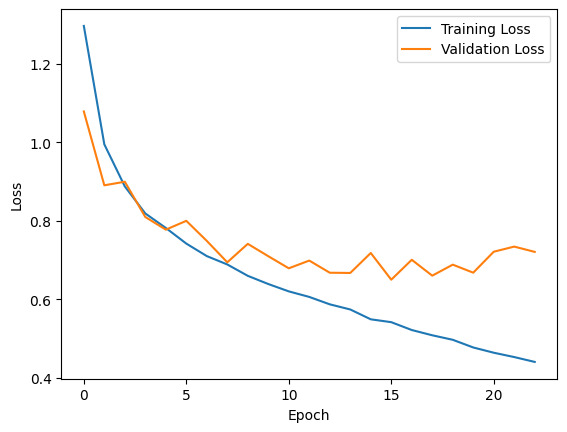

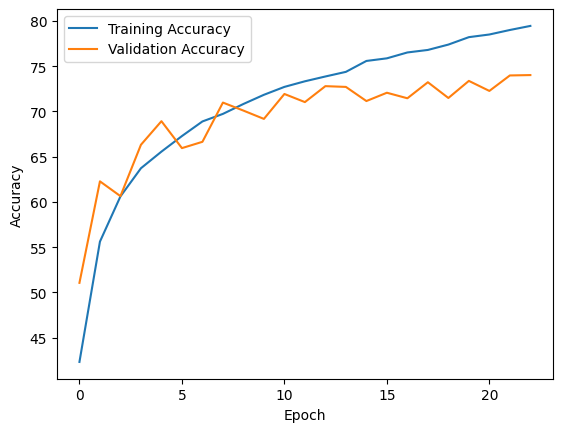

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 43.98it/s]


Test Accuracy: 0.7242
Test Precision: 0.7438
Test Recall: 0.7242
Test F1-score: 0.7259

              precision    recall  f1-score   support

       Anger       0.79      0.72      0.75       916
       Bored       0.84      0.80      0.82      1098
     Disgust       0.46      0.67      0.54       291
        Fear       0.42      0.72      0.53       308
       Happy       0.84      0.59      0.69      1914
     Neutral       0.70      0.68      0.69      2226
    Question       0.80      0.91      0.85      1139
         Sad       0.72      0.75      0.74       857
    Surprise       0.63      0.83      0.72       728

    accuracy                           0.72      9477
   macro avg       0.69      0.74      0.70      9477
weighted avg       0.74      0.72      0.73      9477



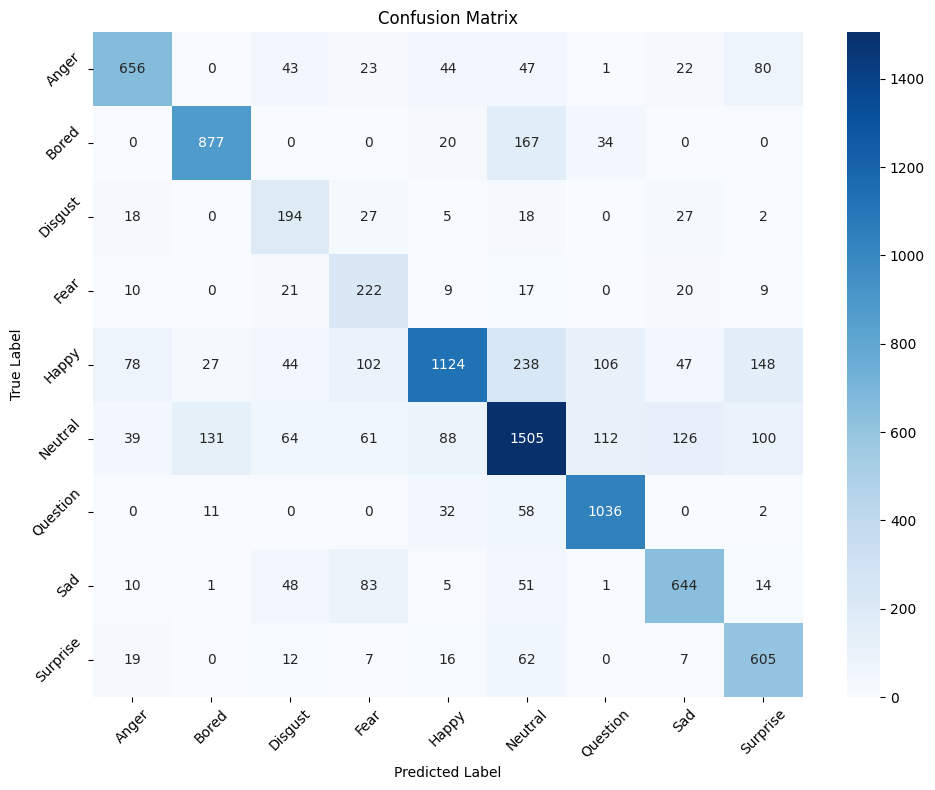

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)